In [1]:
import fastai
from fastai import *
from fastai.text import * 
from fastai.text.models import *
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import pandas as pd
from sklearn.metrics import confusion_matrix, accuracy_score
import swifter
import nltk
from nltk.corpus import stopwords
import re 
from bs4 import BeautifulSoup
from sklearn.metrics import precision_score, recall_score
from nltk.stem.snowball import SnowballStemmer

In [2]:
stops={}

In [3]:
#PREPROCEESING THE TEXT

def text_preprocessing(text, language, minWordSize):
    
    # remove html
    text_html = BeautifulSoup(text,"html.parser" ).get_text()
    
    # remove non-letters
    text_non_letters = re.sub("[^a-zA-Z']", " ", text_html) 
        
    # convert to lower-case
    text_lower = text_non_letters.lower()
    
    # remove stop words
    text_no_stop_words = ' '
    for w in text_lower.split():
        if w not in stops:  
            text_no_stop_words = text_no_stop_words + w + ' '  
    
    # do stemming
    text_stemmer = ' '
    stemmer = SnowballStemmer(language)
    for w in text_no_stop_words.split():
        text_stemmer = text_stemmer + stemmer.stem(w) + ' '
         
    # remove short words
    text_no_short_words = ' '
    for w in text_stemmer.split(): 
        if len(w) >=minWordSize:
            text_no_short_words = text_no_short_words + w + ' '
            
    return text_no_short_words

In [4]:
#PREPROCEESING THE TEXT

def text_preprocessing_simple(text, language, minWordLength):
    
    # remove html
    text_html = BeautifulSoup(text,"html.parser" ).get_text()
    
    # remove non-letters
    text_non_letters = re.sub("[^a-zA-Z']", " ", text_html) 
        
    # convert to lower-case
    text_lower = text_non_letters.lower()
    return text_lower

In [5]:
def text_preprocessing_simple_deemojify(text):
    #     text = text.encode('ascii', 'ignore').decode('ascii')
    text_non_letters = re.sub("[^a-zA-Z']", " ", text) 
        
    # convert to lower-case
    text_lower = text_non_letters.lower()
    return text_lower

In [6]:
def change_ratings(x):
    if x in [0, 1,2]:
        return -1
    elif x == 3:
        return 0
    else:
        return 1

In [7]:
def get_old_data():
    #load and prepare old data
    df_reviews = pd.read_csv('Input_data/Old_data_reviews.csv',sep=',',quotechar='"' ) #contains the reviews from Facebook and Tripadvisor
    df_cat_labels = pd.read_csv('Input_data/Old_data_categorisation_labels.csv',sep=',',quotechar='"') # contains the classlabels of the reviews
    df_merged_data = pd.merge(df_cat_labels,df_reviews,how='left',left_on='review_id',right_on='id')

    # Drop unnecessary columns
    df_merged_data = df_merged_data.drop(['labeler_id', 'post_type', 'datetime_posted','likes', 'traveler_type',
                        'rating_food','rating_service', 'rating_environment', 'rating_value',
                         'reviewer_id','source_subject_id','id_x','review_id','id_y','source'],axis=1)

    #select english reviews
    olddata =  df_merged_data.loc[df_merged_data['language'] == 'en']
    olddata['sentiment'] = olddata['rating'].apply(change_ratings)
    reviews_old = olddata['text'].values
    sentiment_old=olddata['sentiment'].values
    return reviews_old, sentiment_old

In [8]:
def get_new_data():
    #load and prepare new data
    newdata=pd.read_csv('Input_data/New_data.csv')
    #Split category column 
    newdata['category']=newdata['Categories'].apply(lambda x:x.split(';'))

    def category_includer(data,string):    
        for i in range(len(data)):
            data.loc[i,string]=0
            column=list(data.loc[i,'category'])
            if string in column:
                data.loc[i,string]=1
        return data

    newdata=category_includer(newdata,'experience')
    newdata=category_includer(newdata,'service')
    newdata=category_includer(newdata,'consistency')
    newdata=category_includer(newdata,'value')
    newdata=category_includer(newdata,'food')
    newdata=category_includer(newdata,'convenience')

    #dropping the two columns and filter only English
    newdata=newdata.drop(['Categories','category'],axis=1)
    newdata=newdata[newdata['Language']=="eng"]
    reviews_new= newdata['Text'].values
    sentiment_new = newdata['Sentiment'].values

    return reviews_new, sentiment_new

In [9]:
def get_new_translated_data():
    newdata = pd.read_csv('Input_data/newdata.csv')
    newdata['Text']=newdata['Integration Type']+" "+newdata['Text'].apply(text_preprocessing_simple_deemojify)
    reviews_new= newdata['Text'].values
    sentiment_new = newdata['Sentiment'].values
    return reviews_new, sentiment_new

In [10]:
def get_all_data():
    reviews_old, sentiment_old = get_old_data()
    reviews_new, sentiment_new = get_new_data()
    reviews = list(reviews_old) + list(reviews_new)
    sentiment = list(sentiment_old) + list(sentiment_new)
    return reviews, sentiment

In [11]:
def run_preprocessing(preprocess_fn, reviews_train, reviews_test, language, minWordLength):
    for i in range(len(reviews_train)):
        reviews_train[i] = preprocess_fn(reviews_train[i], language, minWordLength)
    for i in range(len(reviews_test)):
        reviews_test[i] = preprocess_fn(reviews_test[i], language, minWordLength)

In [12]:
def preprocess_data(type_data="all", preprocessing="all"):
    #Get data
    if type_data == "all":
        reviews, sentiments = get_all_data()
    elif type_data == "old":
        reviews, sentiments = get_old_data()
    else:
        reviews, sentiments = get_new_translated_data()

    #test train split
    reviews_train, reviews_test, sentiment_train, sentiment_test = train_test_split(reviews, sentiments, test_size=0.2,random_state=0,stratify=sentiments)

    #bag of words
    language = 'english'
    minWordLength = 2 # shorter words will be removed
    
    if preprocessing =="all":
        run_preprocessing(text_preprocessing, reviews_train, reviews_test, language, minWordLength)
    else:
        run_preprocessing(text_preprocessing_simple, reviews_train, reviews_test, language, minWordLength)
    return reviews_train, reviews_test, sentiment_train, sentiment_test


In [13]:
def get_accuracy_matrix(learn, predictions, targets, losses):
    interp = ClassificationInterpretation(learn, predictions, targets, losses)
    
    accuracy_matrix=pd.crosstab(predictions, targets)
    accuracy_matrix2=accuracy_matrix.copy()
    accuracy_matrix2=accuracy_matrix2.rename(columns={0:-1,1:0,2:1})
    accuracy_matrix2=accuracy_matrix2.rename(index={0: -1, 1:0, 2: 1})
    accuracy_matrix2 = accuracy_matrix2.T

    precision_minus_1=accuracy_matrix[0][0]/accuracy_matrix.sum(1)[0]
    precision_0 = accuracy_matrix[1][1]/accuracy_matrix.sum(1)[1]
    precision_1 = accuracy_matrix[2][2]/accuracy_matrix.sum(1)[2]
    precision=[precision_minus_1,precision_0,precision_1]
    recall_minus_1 = accuracy_matrix[0][0]/accuracy_matrix.sum(0)[0]
    recall_0 = accuracy_matrix[1][1]/accuracy_matrix.sum(0)[1]
    recall_1 = accuracy_matrix[2][2]/accuracy_matrix.sum(0)[2]
    recall=[recall_minus_1,recall_0,recall_1]
    weighted_precision = (precision[0]*accuracy_matrix.sum(0)[0]+ precision[1]*accuracy_matrix.sum(0)[1]+ precision[2]*accuracy_matrix.sum(0)[2])/sum(accuracy_matrix.sum(0))
    weighted_recall = (recall[0]*accuracy_matrix.sum(1)[0]+ recall[1]*accuracy_matrix.sum(1)[1]+ recall[2]*accuracy_matrix.sum(1)[2])/sum(accuracy_matrix.sum(1))
    return interp, weighted_precision, weighted_recall

In [14]:
def train_model(type_data="all", preprocessing="all"):
    reviews_train, reviews_test, sentiment_train, sentiment_test = preprocess_data(type_data, preprocessing)
    newdata = pd.read_pickle('newdata.pkl')
    newdata = newdata[newdata['Language']=='eng']
    reviews_new = list(newdata['Text'].values)
    sentiments_new = list(newdata['Sentiment'].values)
#     newdata = pd.DataFrame(list(zip(reviews_new, sentiments_new)), columns=['text', 'labels'])
    # Create language databunch
    data_lm = TextLMDataBunch.from_df(train_df = pd.DataFrame({'text': reviews_train, 'labels': sentiment_train}), 
                                      valid_df = pd.DataFrame({'text': reviews_test, 'labels':sentiment_test}), 
                                      path = "",
                                     text_cols=0,
                                     label_cols=1)

    # Create classifier databunch
    data_clas = TextClasDataBunch.from_df(path = "", 
                                          train_df = pd.DataFrame({'text': reviews_train, 'labels': sentiment_train}),
                                          valid_df = pd.DataFrame({'text': reviews_test, 'labels': sentiment_test}), 
                                          vocab=data_lm.train_ds.vocab, bs=16,
                                         text_cols=0,
                                     label_cols=1)
    learn = language_model_learner(data_lm, AWD_LSTM, pretrained=True, drop_mult=0.3)
    learn.fit_one_cycle(1, 1e-2)
    learn.unfreeze()
    learn.fit_one_cycle(5, 1e-3, moms=(0.8,0.7))
    learn.save_encoder('fine_tuned_enc')
    learn = text_classifier_learner(data_clas, AWD_LSTM,drop_mult=0.2);
    learn.load_encoder('fine_tuned_enc')
    learn.fit_one_cycle(1, 2e-2, moms=(0.8,0.7))
    learn.freeze_to(-2)
    learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))
    learn.freeze_to(-3)
    learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))
    learn.unfreeze()
    learn.fit_one_cycle(10, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

    preds, targets = learn.get_preds()
    predictions = np.argmax(preds, axis = 1)
    
    accuracy_matrix=pd.crosstab(predictions, targets)
    accuracy_matrix2=accuracy_matrix.copy()
    accuracy_matrix2=accuracy_matrix2.rename(columns={0:-1,1:0,2:1})
    accuracy_matrix2=accuracy_matrix2.rename(index={0: -1, 1:0, 2: 1})
    accuracy_matrix2 = accuracy_matrix2.T
    
    precision_minus_1=accuracy_matrix[0][0]/accuracy_matrix.sum(1)[0]
    precision_0 = accuracy_matrix[1][1]/accuracy_matrix.sum(1)[1]
    precision_1 = accuracy_matrix[2][2]/accuracy_matrix.sum(1)[2]
    precision=[precision_minus_1,precision_0,precision_1]
    recall_minus_1 = accuracy_matrix[0][0]/accuracy_matrix.sum(0)[0]
    recall_0 = accuracy_matrix[1][1]/accuracy_matrix.sum(0)[1]
    recall_1 = accuracy_matrix[2][2]/accuracy_matrix.sum(0)[2]
    recall=[recall_minus_1,recall_0,recall_1]
    weighted_precision = (precision[0]*accuracy_matrix.sum(0)[0]+ precision[1]*accuracy_matrix.sum(0)[1]+ precision[2]*accuracy_matrix.sum(0)[2])/sum(accuracy_matrix.sum(0))
    weighted_recall = (recall[0]*accuracy_matrix.sum(1)[0]+ recall[1]*accuracy_matrix.sum(1)[1]+ recall[2]*accuracy_matrix.sum(1)[2])/sum(accuracy_matrix.sum(1))
    learn.export('train_'+ type_data + '_preprocess_' + preprocessing + '_ulmfit.pkl');
    
    newdata['pred'] = newdata['Text'].apply(lambda txt: str(learn.predict(txt)[0]))
    
    accuracy_matrix_test = pd.crosstab(newdata.pred,newdata.Sentiment)
    accuracy_matrix_test=accuracy_matrix_test.rename(columns={-1:0,0:1,1:2})
    accuracy_matrix_test=accuracy_matrix_test.rename(index={-1:0,0:1,1:2})

    precision_minus_1=accuracy_matrix_test[0][0]/accuracy_matrix_test.sum(1)[0]
    precision_0 = accuracy_matrix_test[1][1]/accuracy_matrix_test.sum(1)[1]
    precision_1 = accuracy_matrix_test[2][2]/accuracy_matrix_test.sum(1)[2]
    precision=[precision_minus_1,precision_0,precision_1]
    recall_minus_1 = accuracy_matrix_test[0][0]/accuracy_matrix_test.sum(0)[0]
    recall_0 = accuracy_matrix_test[1][1]/accuracy_matrix_test.sum(0)[1]
    recall_1 = accuracy_matrix_test[2][2]/accuracy_matrix_test.sum(0)[2]
    recall=[recall_minus_1,recall_0,recall_1]
    weighted_precision_test = (precision[0]*accuracy_matrix_test.sum(0)[0]+ precision[1]*accuracy_matrix_test.sum(0)[1]+ precision[2]*accuracy_matrix_test.sum(0)[2])/sum(accuracy_matrix_test.sum(0))
    weighted_recall_test = (recall[0]*accuracy_matrix_test.sum(1)[0]+ recall[1]*accuracy_matrix_test.sum(1)[1]+ recall[2]*accuracy_matrix_test.sum(1)[2])/sum(accuracy_matrix_test.sum(1))
    
    return learn, accuracy_matrix, weighted_precision, weighted_recall, accuracy_matrix_test, weighted_precision_test, weighted_recall_test

## Corrected Labels

In [15]:
reviews_train, reviews_test, sentiment_train, sentiment_test = preprocess_data("new", "simple")
newdata = pd.read_pickle('newdata.pkl')
newdata = newdata[newdata['Language']=='eng']
reviews_new = list((newdata['Integration Type'] + " "+ newdata['Text']).values)
sentiments_new = list(newdata['Sentiment'].values)
#     newdata = pd.DataFrame(list(zip(reviews_new, sentiments_new)), columns=['text', 'labels'])
# Create language databunch
data_lm = TextLMDataBunch.from_df(train_df = pd.DataFrame({'text': reviews_train, 'labels': sentiment_train}), 
                                  valid_df = pd.DataFrame({'text': reviews_test, 'labels':sentiment_test}), 
                                  test_df =  pd.DataFrame({'text': reviews_new, 'labels':sentiments_new}),
                                  path = "",
                                  text_cols=0,
                                  label_cols=1)

# Create classifier databunch
data_clas = TextClasDataBunch.from_df(path = "", 
                                      train_df = pd.DataFrame({'text': reviews_train, 'labels': sentiment_train}),
                                      valid_df = pd.DataFrame({'text': reviews_test, 'labels': sentiment_test}), 
                                      test_df =  pd.DataFrame({'text': reviews_new, 'labels':sentiments_new}),
                                      vocab=data_lm.train_ds.vocab, bs=16,
                                      text_cols=0,
                                      label_cols=1)


In [16]:
learn = language_model_learner(data_lm, AWD_LSTM, pretrained=True, drop_mult=0.5)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 5.75E-02
Min loss divided by 10: 3.63E-02


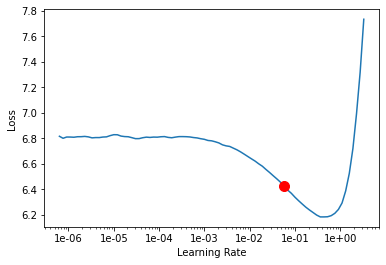

In [17]:
learn.lr_find()
learn.recorder.plot(suggestion=True)
min_grad_lr = learn.recorder.min_grad_lr

In [18]:
learn.fit_one_cycle(1, min_grad_lr)

epoch,train_loss,valid_loss,accuracy,time
0,5.205129,4.654810,0.207626,00:17


In [19]:
learn.freeze_to(-1)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 9.12E-07
Min loss divided by 10: 8.32E-03


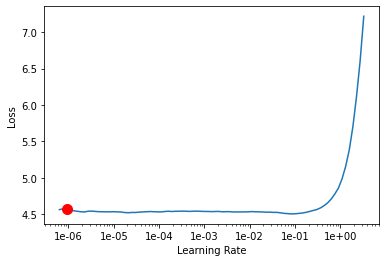

In [20]:
learn.lr_find()
learn.recorder.plot(suggestion=True)
min_grad_lr = learn.recorder.min_grad_lr

In [21]:
learn.fit_one_cycle(2, min_grad_lr)

epoch,train_loss,valid_loss,accuracy,time
0,4.545962,4.654993,0.207999,00:17
1,4.532264,4.655043,0.208098,00:18


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.91E-04
Min loss divided by 10: 6.31E-04


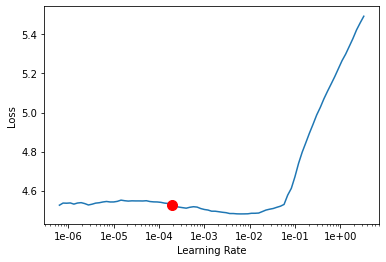

In [22]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot(suggestion=True)
min_grad_lr = learn.recorder.min_grad_lr

In [23]:
learn.fit_one_cycle(5, 2e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.409550,4.474406,0.222594,00:18
1,4.255944,4.366595,0.231796,00:18
2,4.007928,4.341654,0.236136,00:18
3,3.741102,4.355030,0.235355,00:18
4,3.547300,4.382237,0.234834,00:18


In [24]:
learn.save_encoder('fine_tuned_enc')
learn = text_classifier_learner(data_clas, AWD_LSTM,drop_mult=0.2);
learn.load_encoder('fine_tuned_enc')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (8365 items)
x: TextList
xxbos google mybusiness after reading the very good reviews of middletons i was quite excited to eat here unfortunately the xxunk xxunk thin quite quickly we arrived at the restaurant and the staff seemed friendly enough the service was quite quick and we received complimentary water as soon as we sat down after xxunk the menu we decided on calamari for a starter which was just over the calamari was good but it was a very small serving for the price for a main i had a burger which was adequate nothing special especially as half the burger was lukewarm and the other half was hot my partner had the porterhouse steak which was around but quite frankly it wasn t worth this there was a large steak what looked like a squashed mushroom and a tomato with some fries we were very disappointed by this food was average but highly priced so unfortunately we shall not be eating here again,xxbos facebook thank you,xxbos ins

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 2.09E-02


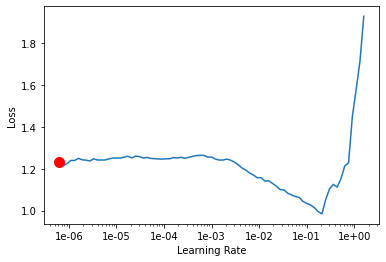

In [25]:
learn.lr_find()
learn.recorder.plot(suggestion=True)
min_grad_lr = learn.recorder.min_grad_lr

In [26]:
learn.fit_one_cycle(1, 1e-02, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.455809,0.396344,0.861855,01:08


epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.58E-06
Min loss divided by 10: 1.91E-07


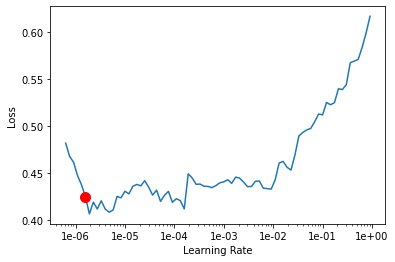

In [27]:
learn.freeze_to(-2)
learn.lr_find()
learn.recorder.plot(suggestion=True)
min_grad_lr = learn.recorder.min_grad_lr

In [28]:
learn.fit_one_cycle(1, min_grad_lr, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.421339,0.393837,0.856597,01:07


epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 6.31E-04


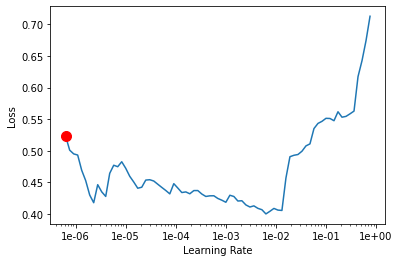

In [29]:
learn.freeze_to(-3)
learn.lr_find()
learn.recorder.plot(suggestion=True)
min_grad_lr = learn.recorder.min_grad_lr

In [30]:
learn.fit_one_cycle(1, min_grad_lr, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.432320,0.396618,0.858031,01:17


epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 9.12E-07
Min loss divided by 10: 1.74E-04


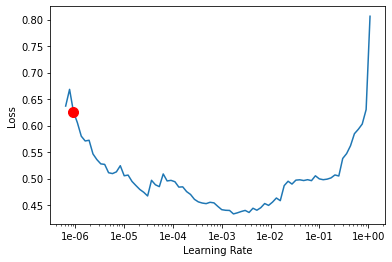

In [31]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot(suggestion=True)
min_grad_lr = learn.recorder.min_grad_lr

In [32]:
learn.fit_one_cycle(10, 2e-04, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.411774,0.388241,0.859943,01:08
1,0.407380,0.361275,0.875239,01:13
2,0.308939,0.345067,0.879541,01:27
3,0.274331,0.364955,0.867591,01:17
4,0.229345,0.395833,0.877151,01:08
5,0.150657,0.384260,0.878107,01:09
6,0.091850,0.397075,0.879541,01:15
7,0.072022,0.406759,0.872849,01:12
8,0.075848,0.415211,0.871415,01:28
9,0.082514,0.418423,0.874283,01:09


In [33]:
preds, targets, losses = learn.get_preds(with_loss=True)
predictions = np.argmax(preds, axis = 1)

print("New, Simple")
accuracy_matrix = ClassificationInterpretation(learn, predictions, targets, losses)
accuracy_matrix.plot_confusion_matrix()
print("Validation Dataset")
print("Weighted Precision", precision_score(targets, predictions, average='weighted'))
print("Weighted Reccall", recall_score(targets, predictions, average='weighted'))

preds, targets, losses = learn.get_preds(ds_type="Test", with_loss=True)
predictions = np.argmax(preds, axis = 1)
accuracy_matrix = ClassificationInterpretation(learn, predictions, targets, losses)
accuracy_matrix.plot_confusion_matrix()
print("Test Dataset")
accuracy_matrix.plot_confusion_matrix()
print("Weighted Precision",precision_score(targets, predictions, average='weighted'))
print("Weighted Reccall", recall_score(targets, predictions, average='weighted'))

learn.export('train_metdata_ulmfit.pkl');

New, Simple


IndexError: Dimension out of range (expected to be in range of [-1, 0], but got 1)

In [57]:
learn.export('translated and corrected model.pkl');

## New Data for training, No stemming

In [23]:
learn, accuracy_matrix, weighted_precision, weighted_recall, accuracy_matrix_test, weighted_precision_test, weighted_recall_test=train_model("new", "simple")
print("New, Simple")
print(accuracy_matrix)
print("Validation Dataset")
print("Weighted Precision",weighted_precision)
print("Weighted Reccall", weighted_recall)
print("Test Dataset")
print(accuracy_matrix_test)
print("Weighted Precison Test",  weighted_precision_test)
print("Weighted Recall Test", weighted_recall_test)

epoch,train_loss,valid_loss,accuracy,time
0,5.344902,4.818928,0.180725,00:17


epoch,train_loss,valid_loss,accuracy,time
0,4.762004,4.617584,0.202101,00:16
1,4.582280,4.476658,0.218330,00:16
2,4.370599,4.422563,0.221547,00:17
3,4.181284,4.399825,0.225578,00:17
4,4.057448,4.406187,0.225499,00:17


epoch,train_loss,valid_loss,accuracy,time
0,0.671706,0.646440,0.757170,01:03


epoch,train_loss,valid_loss,accuracy,time
0,0.683130,0.648258,0.760038,01:12


epoch,train_loss,valid_loss,accuracy,time
0,0.634595,0.644432,0.768642,01:13


epoch,train_loss,valid_loss,accuracy,time
0,0.562873,0.638407,0.768164,01:18
1,0.525655,0.648869,0.770554,01:23
2,0.507531,0.676790,0.768164,01:17
3,0.421858,0.716239,0.760516,01:12
4,0.369229,0.809384,0.753824,01:27
5,0.282810,0.876503,0.746654,01:20
6,0.284141,0.931587,0.739962,01:06
7,0.188855,0.957433,0.751912,01:19
8,0.203362,1.030261,0.753824,01:22
9,0.211407,0.979782,0.748088,01:05


New, Simple
col_0    0    1     2
row_0                
0       58   21    60
1       41   70    43
2      230  132  1437
Validation Dataset
Weighted Precision 0.7020845809850452
Weighted Reccall 0.8372479154745112
Test Dataset
Sentiment    0    1     2
pred                     
-1         210   27    93
0           15   71    15
1          658  204  3637
Weighted Precison Test 0.7711300431709036
Weighted Recall Test 0.9069945815542304


In [34]:
learn.predict('Awesome food and restaurant')

(Category 1, tensor(2), tensor([3.6836e-14, 1.2713e-12, 1.0000e+00]))

In [38]:
learn.export('export.pkl')

In [40]:
l = load_learner(".",'export.pkl')

In [41]:
l.predict('Awesome food and restaurant')

(Category 1, tensor(2), tensor([3.6836e-14, 1.2713e-12, 1.0000e+00]))

## New data for training, with stemming

In [50]:
learn, accuracy_matrix, weighted_precision, weighted_recall, accuracy_matrix_test, weighted_precision_test, weighted_recall_test=train_model("new", "all")
print("New, Simple")
print(accuracy_matrix)
print("Validation Dataset")
print("Weighted Precision",weighted_precision)
print("Weighted Reccall", weighted_recall)
print("Test Dataset")
print(accuracy_matrix_test)
print("Weighted Precison Test",  weighted_precision_test)
print("Weighted Recall Test", weighted_recall_test)

/home/arul/anaconda3/envs/ath/lib/python3.7/site-packages/bs4/__init__.py:389: UserWarning: "https://www.valkyriestudios.be" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup


epoch,train_loss,valid_loss,accuracy,time
0,5.908585,5.147351,0.151875,00:08


epoch,train_loss,valid_loss,accuracy,time
0,5.097179,4.878819,0.180357,00:08
1,4.890745,4.643445,0.202835,00:08
2,4.669193,4.532998,0.215000,00:08
3,4.475345,4.494557,0.218371,00:08
4,4.336513,4.489472,0.219129,00:08


epoch,train_loss,valid_loss,accuracy,time
0,0.501210,0.397431,0.872211,00:33


epoch,train_loss,valid_loss,accuracy,time
0,0.433548,0.349709,0.879310,00:34


epoch,train_loss,valid_loss,accuracy,time
0,0.395152,0.326464,0.874239,00:34


epoch,train_loss,valid_loss,accuracy,time
0,0.276599,0.303386,0.891481,00:38
1,0.256259,0.293460,0.886410,00:42
2,0.229936,0.295933,0.896552,00:34
3,0.184770,0.319564,0.883367,00:41
4,0.121085,0.323504,0.890467,00:40
5,0.095024,0.347343,0.878296,00:41
6,0.087869,0.380421,0.882353,00:38
7,0.067997,0.376579,0.880325,00:42
8,0.047322,0.373544,0.879310,00:39
9,0.052153,0.393247,0.877282,00:39


New, Simple
col_0    0   1    2
row_0              
0      132  21   17
1        4   9    8
2       41  30  724
Validation Dataset
Weighted Precision 0.8572593873555393
Weighted Reccall 0.9111503859123793
Test Dataset
labels    0    1     2
pred                  
-1      608   60   214
0        48   98    66
1       227  144  3465
Weighted Precison Test 0.8379501441945325
Weighted Recall Test 0.857059310739877


## Old data for training, No stemming and no stop word filters

In [51]:
learn, accuracy_matrix, weighted_precision, weighted_recall, accuracy_matrix_test, weighted_precision_test, weighted_recall_test=train_model("old", "simple")
print("New, Simple")
print(accuracy_matrix)
print("Validation Dataset")
print("Weighted Precision",weighted_precision)
print("Weighted Reccall", weighted_recall)
print("Test Dataset")
print(accuracy_matrix_test)
print("Weighted Precison Test",  weighted_precision_test)
print("Weighted Recall Test", weighted_recall_test)

epoch,train_loss,valid_loss,accuracy,time
0,4.675793,4.382808,0.223878,00:37


epoch,train_loss,valid_loss,accuracy,time
0,4.208443,4.181471,0.245524,00:40
1,3.954906,3.959342,0.270059,00:40
2,3.626609,3.804894,0.289895,00:40
3,3.369307,3.727332,0.300688,00:40
4,3.208462,3.713552,0.302305,00:40


epoch,train_loss,valid_loss,accuracy,time
0,0.265474,0.217008,0.918599,02:24


epoch,train_loss,valid_loss,accuracy,time
0,0.216557,0.160888,0.933892,02:27


epoch,train_loss,valid_loss,accuracy,time
0,0.135580,0.116568,0.953133,02:36


epoch,train_loss,valid_loss,accuracy,time
0,0.078720,0.110664,0.958559,02:18
1,0.068201,0.094161,0.968426,02:25
2,0.030822,0.077103,0.973853,02:08
3,0.019416,0.088345,0.976813,02:41
4,0.016053,0.093884,0.978293,02:08
5,0.014307,0.082120,0.980266,02:42
6,0.008344,0.087175,0.980266,02:30
7,0.008263,0.096331,0.980266,02:32
8,0.007604,0.093564,0.977800,02:27
9,0.005080,0.094680,0.979773,02:10


New, Simple
col_0   0    1     2
row_0               
0      64    4     0
1       6  102     1
2       7   23  1820
Validation Dataset
Weighted Precision 0.9791102391888702
Weighted Reccall 0.9825799712458549
Test Dataset
labels    0    1     2
pred                  
-1      238   30   118
0       533  142   481
1       112  130  3146
Weighted Precison Test 0.82333413799613
Weighted Recall Test 0.7086595078205956


## Old data for training, With stemming and stop words filter

In [52]:
learn, accuracy_matrix, weighted_precision, weighted_recall, accuracy_matrix_test, weighted_precision_test, weighted_recall_test=train_model("old", "all")
print("New, Simple")
print(accuracy_matrix)
print("Validation Dataset")
print("Weighted Precision",weighted_precision)
print("Weighted Reccall", weighted_recall)
print("Test Dataset")
print(accuracy_matrix_test)
print("Weighted Precison Test",  weighted_precision_test)
print("Weighted Recall Test", weighted_recall_test)

epoch,train_loss,valid_loss,accuracy,time
0,5.021291,4.692528,0.200357,00:33


epoch,train_loss,valid_loss,accuracy,time
0,4.526930,4.475866,0.222341,00:35
1,4.262245,4.235905,0.246499,00:36
2,3.942935,4.074142,0.265344,00:36
3,3.682522,3.989883,0.277443,00:36
4,3.537864,3.975934,0.278769,00:36


epoch,train_loss,valid_loss,accuracy,time
0,0.261477,0.227974,0.918599,02:17


epoch,train_loss,valid_loss,accuracy,time
0,0.217068,0.161254,0.939319,02:20


epoch,train_loss,valid_loss,accuracy,time
0,0.147842,0.118912,0.955106,02:27


epoch,train_loss,valid_loss,accuracy,time
0,0.075863,0.104161,0.964480,02:10
1,0.079051,0.080473,0.973360,02:17
2,0.040725,0.072297,0.977306,02:01
3,0.027082,0.074924,0.979280,02:33
4,0.015839,0.073085,0.980266,02:01
5,0.017688,0.079023,0.978786,02:33
6,0.009190,0.066244,0.978786,02:22
7,0.007403,0.076229,0.981253,02:24
8,0.004785,0.074761,0.980266,02:20
9,0.005441,0.078951,0.980266,02:03


New, Simple
col_0   0    1     2
row_0               
0      62    2     0
1      10  109     5
2       5   18  1816
Validation Dataset
Weighted Precision 0.9798786549775163
Weighted Reccall 0.9818738223666391
Test Dataset
labels    0    1     2
pred                  
-1      466   56   235
0       139   41    74
1       278  205  3436
Weighted Precison Test 0.7861575773841087
Weighted Recall Test 0.8173693032749333


## All data, no stemming and no stop words filter

In [53]:
learn, accuracy_matrix, weighted_precision, weighted_recall, accuracy_matrix_test, weighted_precision_test, weighted_recall_test=train_model("all", "simple")
print("New, Simple")
print(accuracy_matrix)
print("Validation Dataset")
print("Weighted Precision",weighted_precision)
print("Weighted Reccall", weighted_recall)
print("Test Dataset")
print(accuracy_matrix_test)
print("Weighted Precison Test",  weighted_precision_test)
print("Weighted Recall Test", weighted_recall_test)

/home/arul/anaconda3/envs/ath/lib/python3.7/site-packages/bs4/__init__.py:389: UserWarning: "https://www.valkyriestudios.be" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup


epoch,train_loss,valid_loss,accuracy,time
0,4.653063,4.424557,0.220938,00:50


epoch,train_loss,valid_loss,accuracy,time
0,4.235130,4.233929,0.243478,00:53
1,3.985912,4.040794,0.264422,00:53
2,3.706315,3.915871,0.280566,00:53
3,3.471212,3.855360,0.289029,00:53
4,3.331177,3.847532,0.291003,00:53


epoch,train_loss,valid_loss,accuracy,time
0,0.315224,0.289059,0.889147,03:16


epoch,train_loss,valid_loss,accuracy,time
0,0.320256,0.233335,0.913375,02:58


epoch,train_loss,valid_loss,accuracy,time
0,0.214178,0.197030,0.936608,03:01


epoch,train_loss,valid_loss,accuracy,time
0,0.153862,0.191787,0.935944,03:07
1,0.118514,0.250161,0.943578,03:07
2,0.097045,0.325558,0.946233,02:45
3,0.072589,0.252950,0.949884,02:49
4,0.045967,0.190514,0.950216,03:15
5,0.032175,0.197037,0.947561,03:20
6,0.025014,0.218933,0.945237,03:13
7,0.025565,0.221446,0.950880,02:54
8,0.013063,0.231569,0.949220,03:10
9,0.010472,0.222711,0.948556,03:00


New, Simple
col_0    0    1     2
row_0                
0      184   12     6
1       19  127    17
2       51   50  2547
Validation Dataset
Weighted Precision 0.9460999272731566
Weighted Reccall 0.9559116344891503
Test Dataset
labels    0    1     2
pred                  
-1      808  115   352
0        41  127   104
1        34   60  3289
Weighted Precison Test 0.8806345705579162
Weighted Recall Test 0.8625084165007728


## All data, with stemming and stop words filters

In [54]:

learn, accuracy_matrix, weighted_precision, weighted_recall, accuracy_matrix_test, weighted_precision_test, weighted_recall_test=train_model("all", "all")
print("New, Simple")
print(accuracy_matrix)
print("Validation Dataset")
print("Weighted Precision",weighted_precision)
print("Weighted Reccall", weighted_recall)
print("Test Dataset")
print(accuracy_matrix_test)
print("Weighted Precison Test",  weighted_precision_test)
print("Weighted Recall Test", weighted_recall_test)

/home/arul/anaconda3/envs/ath/lib/python3.7/site-packages/bs4/__init__.py:389: UserWarning: "https://www.valkyriestudios.be" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup


epoch,train_loss,valid_loss,accuracy,time
0,4.943565,4.700051,0.199762,00:44


epoch,train_loss,valid_loss,accuracy,time
0,4.520302,4.496871,0.221992,00:47
1,4.263268,4.286583,0.242142,00:47
2,3.998870,4.155742,0.258056,00:47
3,3.766071,4.091449,0.267309,00:47
4,3.635593,4.083505,0.268882,00:47


epoch,train_loss,valid_loss,accuracy,time
0,0.296639,0.297900,0.893794,03:06


epoch,train_loss,valid_loss,accuracy,time
0,0.300323,0.229887,0.908397,02:49


epoch,train_loss,valid_loss,accuracy,time
0,0.217801,0.210939,0.924328,02:52


epoch,train_loss,valid_loss,accuracy,time
0,0.167806,0.198494,0.929970,02:57
1,0.133437,0.169816,0.945569,02:56
2,0.105211,0.174563,0.951211,02:36
3,0.074911,0.185035,0.947561,02:40
4,0.048558,0.194357,0.948888,03:05
5,0.037593,0.194678,0.950880,03:09
6,0.021887,0.200290,0.950880,03:03
7,0.025019,0.190900,0.954530,02:45
8,0.012538,0.207416,0.954198,03:00
9,0.011740,0.204269,0.952539,02:51


New, Simple
col_0    0    1     2
row_0                
0      191   10     8
1       17  129    12
2       46   50  2550
Validation Dataset
Weighted Precision 0.9502794218754288
Weighted Reccall 0.9593133911302317
Test Dataset
labels    0    1     2
pred                  
-1      677   78   279
0        17   22    22
1       189  202  3444
Weighted Precison Test 0.8215473575289088
Weighted Recall Test 0.8770755437485549
